# PUBg Finish Placement Prediction


# Player Unknown Battleground

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import gc
import os
import sys

sns.set_style('darkgrid')
sns.set_palette('bone')
pd.options.display.float_format = '{:,.3f}'.format

In [35]:
def toTapleList(list1,list2):
    return list(itertools.product(list1,list2))

In [36]:
# Memory saving function
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Load data

In [37]:
%%time
train = pd.read_csv('train_V2.csv')
train = reduce_mem_usage(train)
test = pd.read_csv('test_V2.csv')
test = reduce_mem_usage(test)
print(train.shape, test.shape)

Memory usage of dataframe is 1.99 MB --> 0.68 MB (Decreased by 65.9%)
Memory usage of dataframe is 1.60 MB --> 0.54 MB (Decreased by 66.5%)
(8999, 29) (7505, 28)
CPU times: user 108 ms, sys: 31.8 ms, total: 140 ms
Wall time: 141 ms


In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8999 entries, 0 to 8998
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               8999 non-null   object 
 1   groupId          8999 non-null   object 
 2   matchId          8999 non-null   object 
 3   assists          8999 non-null   int8   
 4   boosts           8999 non-null   int8   
 5   damageDealt      8999 non-null   float32
 6   DBNOs            8999 non-null   int8   
 7   headshotKills    8999 non-null   int8   
 8   heals            8999 non-null   int8   
 9   killPlace        8999 non-null   int8   
 10  killPoints       8999 non-null   int16  
 11  kills            8999 non-null   int8   
 12  killStreaks      8999 non-null   int8   
 13  longestKill      8999 non-null   float32
 14  matchDuration    8999 non-null   int16  
 15  matchType        8999 non-null   object 
 16  maxPlace         8999 non-null   int8   
 17  numGroups     

In [39]:
null_cnt = train.isnull().sum().sort_values()
print('null count:', null_cnt[null_cnt > 0])
# dropna
train.dropna(inplace=True)

null count: Series([], dtype: int64)


In [40]:
train.describe(include=np.number).drop('count').T

,mean,std,min,25%,50%,75%,max
assists,0.228,0.573,0.000,0.000,0.000,0.000,6.000
boosts,1.129,1.759,0.000,0.000,0.000,2.000,11.000
damageDealt,130.226,170.846,0.000,0.000,80.340,183.650,"2,325.000"
DBNOs,0.652,1.133,0.000,0.000,0.000,1.000,13.000
headshotKills,0.226,0.582,0.000,0.000,0.000,0.000,8.000
heals,1.375,2.666,0.000,0.000,0.000,2.000,29.000
killPlace,47.901,27.483,1.000,24.000,48.000,72.000,100.000
killPoints,507.422,627.486,0.000,0.000,0.000,"1,172.000","2,026.000"
kills,0.922,1.552,0.000,0.000,0.000,1.000,21.000
killStreaks,0.540,0.714,0.000,0.000,0.000,1.000,5.000


# Feature Engineering

In [41]:
all_data = train.append(test, sort=False).reset_index(drop=True)
del train, test
gc.collect()

1712

## new feature

In [42]:
def fillInf(df, val):
    numcols = df.select_dtypes(include='number').columns
    cols = numcols[numcols != 'winPlacePerc']
    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    for c in cols: df[c].fillna(val, inplace=True)

In [43]:
all_data['_totalDistance'] = all_data['rideDistance'] + all_data['walkDistance'] + all_data['swimDistance']
all_data['_healthItems'] = all_data['heals'] + all_data['boosts']
all_data['_headshotKillRate'] = all_data['headshotKills'] / all_data['kills']
all_data['_killPlaceOverMaxPlace'] = all_data['killPlace'] / all_data['maxPlace']
all_data['_killsOverWalkDistance'] = all_data['kills'] / all_data['walkDistance']
#all_data['_killsOverDistance'] = all_data['kills'] / all_data['_totalDistance']
#all_data['_walkDistancePerSec'] = all_data['walkDistance'] / all_data['matchDuration']

fillInf(all_data, 0)

## rank as percent

In [44]:
match = all_data.groupby('matchId')
all_data['killsPerc'] = match['kills'].rank(pct=True).values
all_data['killPlacePerc'] = match['killPlace'].rank(pct=True).values
all_data['walkDistancePerc'] = match['walkDistance'].rank(pct=True).values
#all_data['damageDealtPerc'] = match['damageDealt'].rank(pct=True).values

all_data['walkPerc_killsPerc'] = all_data['walkDistancePerc'] / all_data['killsPerc']
#all_data['walkPerc_kills'] = all_data['walkDistancePerc'] / all_data['kills']
#all_data['kills_walkPerc'] = all_data['kills'] / all_data['walkDistancePerc']

## drop feature

In [45]:
#all_data.drop(['killStreaks','DBNOs'], axis=1, inplace=True)
all_data.drop(['boosts','heals','revives','assists'], axis=1, inplace=True)
all_data.drop(['headshotKills','roadKills','vehicleDestroys','teamKills'], axis=1, inplace=True)
all_data.drop(['rideDistance','swimDistance','matchDuration'], axis=1, inplace=True)
all_data.drop(['rankPoints','killPoints','winPoints'], axis=1, inplace=True)

## grouping

* need to predict the order of places for groups within each match.
* train on group-level instead of the user-level

In [46]:
match = all_data.groupby(['matchId'])
group = all_data.groupby(['matchId','groupId','matchType'])

# target feature (max, min)
agg_col = list(all_data.columns)
exclude_agg_col = ['Id','matchId','groupId','matchType','maxPlace','numGroups','winPlacePerc']
for c in exclude_agg_col:
    agg_col.remove(c)
print(agg_col)

# target feature (sum)
sum_col = ['kills','killPlace','damageDealt','walkDistance','_healthItems']

['damageDealt', 'DBNOs', 'killPlace', 'kills', 'killStreaks', 'longestKill', 'walkDistance', 'weaponsAcquired', ' Id', '_totalDistance', '_healthItems', '_headshotKillRate', '_killPlaceOverMaxPlace', '_killsOverWalkDistance', 'killsPerc', 'killPlacePerc', 'walkDistancePerc', 'walkPerc_killsPerc']


In [47]:
''' match sum, match max, match mean, group sum
'''
match_data = pd.concat([
    match.size().to_frame('m.players'), 
    match[sum_col].sum().rename(columns=lambda s: 'm.sum.' + s), 
    match[sum_col].max().rename(columns=lambda s: 'm.max.' + s),
    match[sum_col].mean().rename(columns=lambda s: 'm.mean.' + s)
    ], axis=1).reset_index()
match_data = pd.merge(match_data, 
    group[sum_col].sum().rename(columns=lambda s: 'sum.' + s).reset_index())
match_data = reduce_mem_usage(match_data)

print(match_data.shape)

Memory usage of dataframe is 2.31 MB --> 1.63 MB (Decreased by 29.3%)
(16461, 24)


In [48]:
''' ranking of kills and killPlace in each match
'''
minKills = all_data.sort_values(['matchId','groupId','kills','killPlace']).groupby(
    ['matchId','groupId','kills']).first().reset_index().copy()
for n in np.arange(5):
    c = 'kills_' + str(n) + '_Place'
    nKills = (minKills['kills'] == n)
    minKills.loc[nKills, c] = minKills[nKills].groupby(['matchId'])['killPlace'].rank().values
    match_data = pd.merge(match_data, minKills[nKills][['matchId','groupId',c]], how='left')
    match_data[c].fillna(0, inplace=True)
match_data = reduce_mem_usage(match_data)
del minKills, nKills

print(match_data.shape)

Memory usage of dataframe is 2.26 MB --> 1.95 MB (Decreased by 13.9%)
(16461, 29)


In [49]:
''' group mean, max, min
'''
all_data = pd.concat([
    group.size().to_frame('players'),
    group.mean(),
    group[agg_col].max().rename(columns=lambda s: 'max.' + s),
    group[agg_col].min().rename(columns=lambda s: 'min.' + s),
    ], axis=1).reset_index()
all_data = reduce_mem_usage(all_data)

print(all_data.shape)

Memory usage of dataframe is 5.21 MB --> 3.47 MB (Decreased by 33.4%)
(16461, 60)


## aggregate feature

In [50]:
numcols = all_data.select_dtypes(include='number').columns.values
numcols = numcols[numcols != 'winPlacePerc']

In [51]:
''' match summary, max
'''
all_data = pd.merge(all_data, match_data)
del match_data
gc.collect()

all_data['enemy.players'] = all_data['m.players'] - all_data['players']
for c in sum_col:
    all_data['enemy.' + c] = (all_data['m.sum.' + c] - all_data['sum.' + c]) / all_data['enemy.players']
    #all_data['p.sum_msum.' + c] = all_data['sum.' + c] / all_data['m.sum.' + c]
    #all_data['p.max_mmean.' + c] = all_data['max.' + c] / all_data['m.mean.' + c]
    all_data['p.max_msum.' + c] = all_data['max.' + c] / all_data['m.sum.' + c]
    all_data['p.max_mmax.' + c] = all_data['max.' + c] / all_data['m.max.' + c]
    all_data.drop(['m.sum.' + c, 'm.max.' + c], axis=1, inplace=True)
    
fillInf(all_data, 0)
print(all_data.shape)

(16461, 92)


In [52]:
''' match rank
'''
match = all_data.groupby('matchId')
matchRank = match[numcols].rank(pct=True).rename(columns=lambda s: 'rank.' + s)
all_data = reduce_mem_usage(pd.concat([all_data, matchRank], axis=1))
rank_col = matchRank.columns
del matchRank
gc.collect()

# instead of rank(pct=True, method='dense')
match = all_data.groupby('matchId')
matchRank = match[rank_col].max().rename(columns=lambda s: 'max.' + s).reset_index()
all_data = pd.merge(all_data, matchRank)
for c in numcols:
    all_data['rank.' + c] = all_data['rank.' + c] / all_data['max.rank.' + c]
    all_data.drop(['max.rank.' + c], axis=1, inplace=True)
del matchRank
gc.collect()

print(all_data.shape)

Memory usage of dataframe is 12.48 MB --> 8.90 MB (Decreased by 28.7%)
(16461, 146)


## killPlace rank of group and kills

In [53]:
''' TODO: incomplete
''' 
killMinorRank = all_data[['matchId','min.kills','max.killPlace']].copy()
group = killMinorRank.groupby(['matchId','min.kills'])
killMinorRank['rank.minor.maxKillPlace'] = group.rank(pct=True).values
all_data = pd.merge(all_data, killMinorRank)

killMinorRank = all_data[['matchId','max.kills','min.killPlace']].copy()
group = killMinorRank.groupby(['matchId','max.kills'])
killMinorRank['rank.minor.minKillPlace'] = group.rank(pct=True).values
all_data = pd.merge(all_data, killMinorRank)

del killMinorRank
gc.collect()

0

## drop constant feature

In [54]:
# drop constant column
constant_column = [col for col in all_data.columns if all_data[col].nunique() == 1]
print('drop columns:', constant_column)
all_data.drop(constant_column, axis=1, inplace=True)

drop columns: ['rank.maxPlace', 'rank.numGroups']


## encode

In [55]:
'''
solo  <-- solo,solo-fpp,normal-solo,normal-solo-fpp
duo   <-- duo,duo-fpp,normal-duo,normal-duo-fpp,crashfpp,crashtpp
squad <-- squad,squad-fpp,normal-squad,normal-squad-fpp,flarefpp,flaretpp
'''
mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
all_data['matchType'] = all_data['matchType'].apply(mapper)

all_data = pd.concat([all_data, pd.get_dummies(all_data['matchType'], prefix='matchType')], axis=1)

In [56]:
cols = [col for col in all_data.columns if col not in ['Id','matchId','groupId']]
for i, t in all_data.loc[:, cols].dtypes.iteritems():
    if t == object:
        all_data[i] = pd.factorize(all_data[i])[0]

all_data = reduce_mem_usage(all_data)
all_data.head()

Memory usage of dataframe is 9.07 MB --> 8.79 MB (Decreased by 3.1%)


,matchId,groupId,matchType,players,damageDealt,DBNOs,killPlace,kills,killStreaks,longestKill,maxPlace,numGroups,walkDistance,weaponsAcquired,winPlacePerc,_totalDistance,_healthItems,_headshotKillRate,_killPlaceOverMaxPlace,_killsOverWalkDistance,killsPerc,killPlacePerc,walkDistancePerc,walkPerc_killsPerc,max.damageDealt,max.DBNOs,max.killPlace,max.kills,max.killStreaks,max.longestKill,max.walkDistance,max.weaponsAcquired,max. Id,max._totalDistance,max._healthItems,max._headshotKillRate,max._killPlaceOverMaxPlace,max._killsOverWalkDistance,max.killsPerc,max.killPlacePerc,...,rank.walkPerc_killsPerc,rank.max.damageDealt,rank.max.DBNOs,rank.max.killPlace,rank.max.kills,rank.max.killStreaks,rank.max.longestKill,rank.max.walkDistance,rank.max.weaponsAcquired,rank.max._totalDistance,rank.max._healthItems,rank.max._headshotKillRate,rank.max._killPlaceOverMaxPlace,rank.max._killsOverWalkDistance,rank.max.killsPerc,rank.max.killPlacePerc,rank.max.walkDistancePerc,rank.max.walkPerc_killsPerc,rank.min.damageDealt,rank.min.DBNOs,rank.min.killPlace,rank.min.kills,rank.min.killStreaks,rank.min.longestKill,rank.min.walkDistance,rank.min.weaponsAcquired,rank.min._totalDistance,rank.min._healthItems,rank.min._headshotKillRate,rank.min._killPlaceOverMaxPlace,rank.min._killsOverWalkDistance,rank.min.killsPerc,rank.min.killPlacePerc,rank.min.walkDistancePerc,rank.min.walkPerc_killsPerc,rank.minor.maxKillPlace,rank.minor.minKillPlace,matchType_duo,matchType_solo,matchType_squad
0,0000a43bce5eec,7bd08592bb25e2,0,1,0.000,0.000,41.000,0.000,0.000,0.000,28.000,28.000,"2,723.000",3.000,0.667,"2,723.000",2.000,0.000,1.464,0.000,1.000,1.000,1.000,1.000,0.000,0,41,0,0,0.000,"2,723.000",3,-1,"2,723.000",2,0.000,1.464,0.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,1.000
1,0000eb01ea6cdd,338a69335655a6,0,1,210.900,1.000,29.000,1.000,1.000,92.570,28.000,27.000,988.300,5.000,0.593,988.300,4.000,1.000,1.036,0.001,0.500,1.000,1.000,2.000,210.900,1,29,1,1,92.570,988.300,5,-1,988.300,4,1.000,1.036,0.001,0.500,1.000,...,1.000,0.500,0.500,1.000,0.500,0.500,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.500,0.500,1.000,1.000,1.000,0.500,0.500,1.000,0.500,0.500,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.500,0.500,1.000,1.000,1.000,1.000,1.000,0.000,0.000,1.000
2,0000eb01ea6cdd,e89636a86735d3,0,1,300.000,2.000,11.000,3.000,3.000,19.330,28.000,27.000,30.460,2.000,0.778,30.460,0.000,0.333,0.393,0.098,1.000,0.500,0.500,0.500,300.000,2,11,3,3,19.330,30.460,2,-1,30.460,0,0.333,0.393,0.098,1.000,0.500,...,0.500,1.000,1.000,0.500,1.000,1.000,0.500,0.500,0.500,0.500,0.500,0.500,0.500,1.000,1.000,0.500,0.500,0.500,1.000,1.000,0.500,1.000,1.000,0.500,0.500,0.500,0.500,0.500,0.500,0.500,1.000,1.000,0.500,0.500,0.500,1.000,1.000,0.000,0.000,1.000
3,00086e740a5804,4018d80e8ad32a,1,1,177.400,0.000,62.000,0.000,0.000,0.000,98.000,95.000,458.700,4.000,0.454,458.700,1.000,0.000,0.633,0.000,1.000,1.000,1.000,1.000,177.400,0,62,0,0,0.000,458.700,4,-1,458.700,1,0.000,0.633,0.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,0.000
4,0008c31a9be4a7,26d4045668cf95,0,1,0.000,0.000,74.000,0.000,0.000,0.000,30.000,30.000,323.400,3.000,nan,323.400,0.000,0.000,2.467,0.000,1.000,1.000,1.000,1.000,0.000,0,74,0,0,0.000,323.400,3,0,323.400,0,0.000,2.467,0.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,1.000


# Predict

In [57]:
X_train = all_data[all_data['winPlacePerc'].notnull()].reset_index(drop=True)
X_test = all_data[all_data['winPlacePerc'].isnull()].drop(['winPlacePerc'], axis=1).reset_index(drop=True)
del all_data
gc.collect()

Y_train = X_train.pop('winPlacePerc')
X_test_grp = X_test[['matchId','groupId']].copy()

# drop matchId,groupId
X_train.drop(['matchId','groupId'], axis=1, inplace=True)
X_test.drop(['matchId','groupId'], axis=1, inplace=True)

X_train_cols = X_train.columns

print(X_train.shape, X_test.shape)

(8972, 146) (7489, 146)


In [58]:
#print(pd.DataFrame([[val for val in dir()], [sys.getsizeof(eval(val)) for val in dir()]],
#                   index=['name','size']).T.sort_values('size', ascending=False).reset_index(drop=True)[:10])

In [59]:
from keras import optimizers, regularizers
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Dropout, BatchNormalization, PReLU
from keras.models import load_model
from keras.models import Sequential

def createModel():
    model = Sequential()
    model.add(Dense(512, kernel_initializer='he_normal', input_dim=X_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(256, kernel_initializer='he_normal'))
    model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(128, kernel_initializer='he_normal'))
    model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(lr=0.005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    #model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])
    
    return model

import tensorflow as tf
print(tf.__version__)

In [60]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10, verbose=0):
    ''' Wrapper function to create a LearningRateScheduler with step decay schedule. '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule, verbose)

lr_sched = step_decay_schedule(initial_lr=0.001, decay_factor=0.97, step_size=1, verbose=1)
early_stopping = EarlyStopping(monitor='val_mean_absolute_error', mode='min', patience=10, verbose=1)

In [61]:
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
np.random.seed(42)
tf.random.set_seed(1234)

#scaler = preprocessing.StandardScaler().fit(X_train)#.astype(float))
#X_train = scaler.transform(X_train)#.astype(float))
#X_test = scaler.transform(X_test)#.astype(float))

model = createModel()
history = model.fit(
        X_train, Y_train,
        epochs=200,
        batch_size=2**15,
        validation_split=0.2,
        callbacks=[lr_sched, early_stopping],
        verbose=2)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/200
1/1 - 2s - loss: 0.1272 - mae: 0.3028 - val_loss: 0.1111 - val_mae: 0.2738 - lr: 0.0010 - 2s/epoch - 2s/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009699999999999999.
Epoch 2/200
1/1 - 0s - loss: 0.0438 - mae: 0.1687 - val_loss: 0.1243 - val_mae: 0.2869 - lr: 9.7000e-04 - 403ms/epoch - 403ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009408999999999999.
Epoch 3/200
1/1 - 0s - loss: 0.0292 - mae: 0.1312 - val_loss: 0.1290 - val_mae: 0.2905 - lr: 9.4090e-04 - 411ms/epoch - 411ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.000912673.
Epoch 4/200
1/1 - 0s - loss: 0.0289 - mae: 0.1281 - val_loss: 0.1304 - val_mae: 0.2912 - lr: 9.1267e-04 - 400ms/epoch - 400ms/step

Epoch 00005: LearningRateScheduler setting learning rate to 0.00088529281.
Epoch 5/200
1/1 - 0s - loss: 0.0298 - mae: 0.1276 - val_loss: 0.1300 - val_mae: 0.2895 - lr: 8.8529e

In [62]:

predictions = model.predict(X_test)

print(X_test.shape)
print(predictions.shape)


(7489, 146)
(7489, 1)


In [63]:
type(history)
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'lr'])


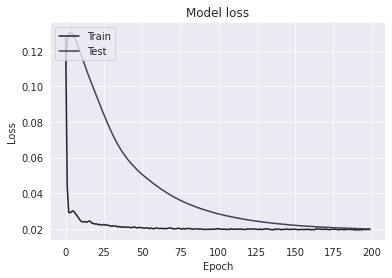

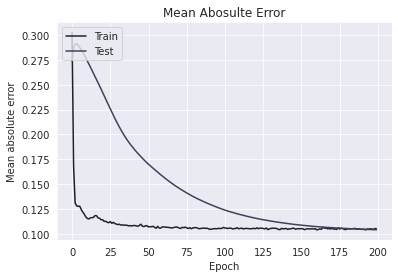

In [64]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation mae values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Abosulte Error')
plt.ylabel('Mean absolute error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## alignment

In [65]:
X_test = pd.read_csv('test_V2.csv')
X_test = X_test.groupby(['matchId','groupId','matchType']).first().reset_index()
X_test = X_test[['matchId','groupId','matchType','numGroups','maxPlace','kills','killPlace']]

group = X_test_grp.groupby(['matchId'])
X_test_grp['winPlacePerc'] = predictions
X_test_grp['_rank.winPlacePerc'] = group['winPlacePerc'].rank(method='min')
X_test = pd.merge(X_test, X_test_grp)

In [66]:
fullgroup = (X_test['numGroups'] == X_test['maxPlace'])

# full group (201366) --> calculate from rank
subset = X_test.loc[fullgroup]
X_test.loc[fullgroup, 'winPlacePerc'] = (subset['_rank.winPlacePerc'].values - 1) / (subset['maxPlace'].values - 1)

# not full group (684872) --> align with maxPlace
subset = X_test.loc[~fullgroup]
gap = 1.0 / (subset['maxPlace'].values - 1)
new_perc = np.around(subset['winPlacePerc'].values / gap) * gap  # half&up
X_test.loc[~fullgroup, 'winPlacePerc'] = new_perc

X_test['winPlacePerc'] = X_test['winPlacePerc'].clip(lower=0,upper=1)

In [67]:
from tqdm import tqdm


print("Checking for anomalies in the winPlacePerc - players with same number of kills should have scores in order of killPlace")

do_correct = True
iteration_number = 1

while do_correct & (iteration_number <= 1000):
    X_test.sort_values(ascending=False, by=["matchId","kills","killPlace","winPlacePerc","groupId"], inplace=True)
    X_test["winPlacePerc_diff"] = X_test["winPlacePerc"].diff()
    X_test["kills_diff"] = X_test["kills"].diff()
    X_test["prev_matchId"] = X_test["matchId"].shift(1)
    X_test["prev_groupId"] = X_test["groupId"].shift(1)
    X_test["prev_winPlacePerc"] = X_test["winPlacePerc"].shift(1)

    df_sub2 = X_test[(X_test["winPlacePerc_diff"] < 0) 
                     & (X_test["kills_diff"] == 0) 
                     & (X_test["matchId"] == X_test["prev_matchId"])]
    anomalies_count = len(df_sub2)

    print("Iteration " + str(iteration_number) + " Anomalies count: " + str(anomalies_count))

    changed_groups = list()

    if anomalies_count > 0:
        print()
        print("Looking for pairs to change...")

        df_sub2["new_winPlacePerc"] = df_sub2["winPlacePerc"] 

        df_sub3 = pd.DataFrame()

        for i in tqdm(range(1, min(15001, max(anomalies_count, 2))), 
                      desc="Identifying unique groups", mininterval=10):
            row = df_sub2.iloc[i - 1]
            id_prev = str(row["prev_matchId"]) + "!" + str(row["prev_groupId"])
            id_cur = str(row["matchId"]) + "!" + str(row["groupId"])
            if (not id_prev in changed_groups) & (not id_cur in changed_groups):
                changed_groups.append(id_prev)
                changed_groups.append(id_cur)
                df_sub3 = df_sub3.append({"matchId": row["matchId"], "groupId": row["prev_groupId"], 
                                          "new_winPlacePerc": row["winPlacePerc"]}, 
                                         sort=False, ignore_index=True)
                df_sub3 = df_sub3.append({"matchId": row["matchId"], "groupId": row["groupId"], 
                                          "new_winPlacePerc": row["prev_winPlacePerc"]}, 
                                         sort=False, ignore_index=True)

        df_sub3.drop_duplicates(inplace=True)
        X_test = X_test.merge(df_sub3, on=["matchId", "groupId"], how="left")
        notna = X_test["new_winPlacePerc"].notna()
        X_test.loc[notna, "winPlacePerc"] = X_test.loc[notna]["new_winPlacePerc"]
        X_test.drop(labels="new_winPlacePerc", axis=1, inplace=True)
        del df_sub2
        del df_sub3
        df_sub2 = None
        df_sub3 = None
        gc.collect()
    else:
        do_correct = False

    iteration_number = iteration_number + 1

if do_correct:
    print("Limit of iterations reached...")

print("Finished correcting winPlacePerc")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Checking for anomalies in the winPlacePerc - players with same number of kills should have scores in order of killPlace
Iteration 1 Anomalies count: 28

Looking for pairs to change...


Identifying unique groups: 100%|██████████| 27/27 [00:00<00:00, 120.04it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Iteration 2 Anomalies count: 1

Looking for pairs to change...


Identifying unique groups: 100%|██████████| 1/1 [00:00<00:00, 122.08it/s]


Iteration 3 Anomalies count: 0
Finished correcting winPlacePerc


In [68]:
# edge cases
X_test.loc[X_test['maxPlace'] == 0, 'winPlacePerc'] = 0
X_test.loc[X_test['maxPlace'] == 1, 'winPlacePerc'] = 1  # nothing
X_test.loc[(X_test['maxPlace'] > 1) & (X_test['numGroups'] == 1), 'winPlacePerc'] = 0
X_test['winPlacePerc'].describe()

count   7,489.000
mean        0.640
std         0.450
min         0.000
25%         0.000
50%         0.980
75%         1.000
max         1.000
Name: winPlacePerc, dtype: float64